# Simple Exploration Notebook - Zillow Prize
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize

이 노트에서, 우리는 질로우 경품 경진대회에서 주어진 데이터를 살펴보도록 하겠습니다. 데이터를 자세히 살펴보기 전 업체에 대해 자세히 알아보겠습니다.

__Zillow:__

질로우는 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다.

__Zestimate:__

"Zestimate"는 각 속성에 대한 수백 개의 데이터 포인트를 분석하는 750만 개의 통꼐 및 기계 학습 모델을 기반으로 추정된 집 값입니다. 또한 중앙 오차 한계를 지속적으로 개선했습니다.(14퍼센트에서 현재 5퍼센트)

__목표:__

Zesimate 추정 잔차 오류를 개선하기 위한 모델 구축

먼저 필요한 모듈을 가져오겠습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.size:    10.0')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 364 ('axes.titlesize:     large   # fontsize of the axes title')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 370 ('axes.labelsize:     medium  # fontsize of the x any y labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 469 ('xtick.labelsize:     medium  # fontsize of the tick labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 489 ('ytick.labelsize:     medium  # fontsize of the tick labels')


먼저 훈련 파일을 살펴보겠습니다.

In [2]:
train_df = pd.read_csv('./input/train_2016_v2.csv', parse_dates=['transactiondate'])
train_df.shape

(90275, 3)

In [3]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


### __Logerror:__
타겟 변수는 logerror 영역입니다. 이 영역에 대해 먼저 분석해보겠습니다.

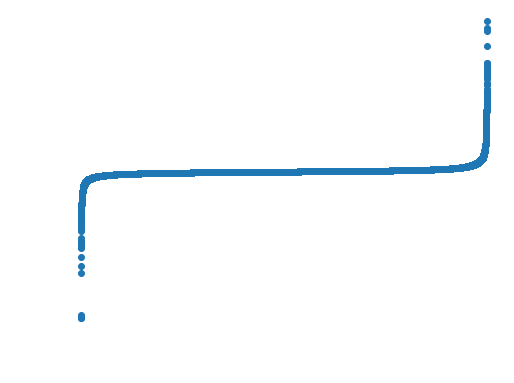

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

양쪽 끝의 이상치를 제거한 후 히스토그램을 그려보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


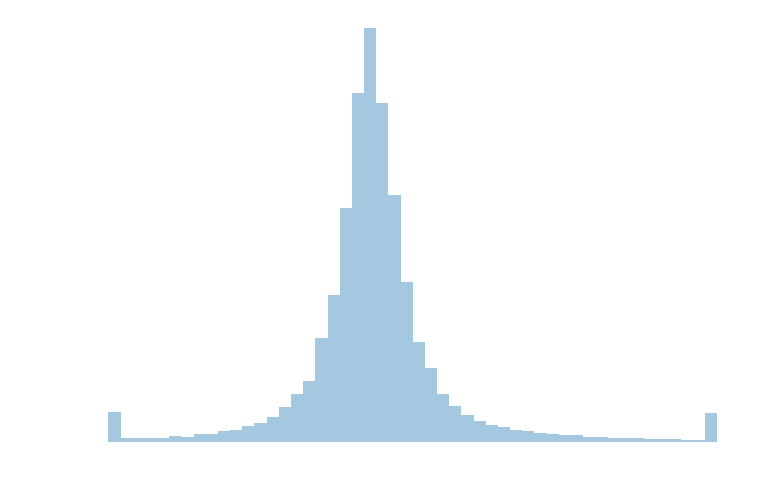

In [5]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'][train_df['logerror']>ulimit] = ulimit
train_df['logerror'][train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

log error는 정규 분포처럼 보입니다.

### Transaction Date:

데이터를 살펴보겠습니다. 먼저 각 월별로 처리를 해보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


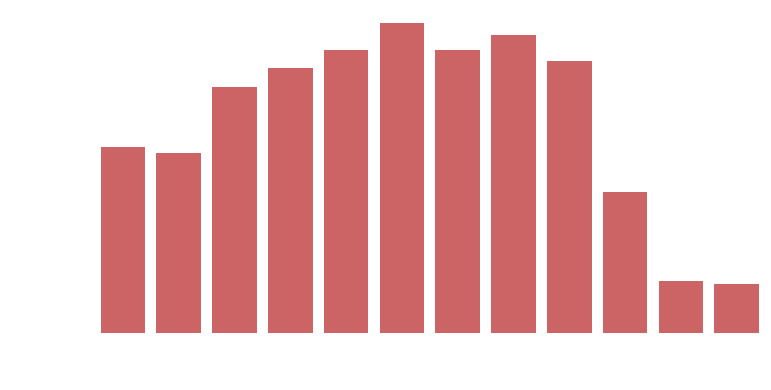

In [6]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurences', fontsize=12)
plt.show()

훈련 데이터는 2016년 10월 15일 이전의 모든 트랜젝션과 이후의 일부 트랜잭션을 포함합니다.

그래서 지난 3개월 동안 짧은 막대가 있습니다.

### parcel id:

In [7]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

대부분의 parcel id가 한번만 나타납니다.

### Properties 2016
properties_2016 파일을 살펴보겠습니다.

In [8]:
prop_df = pd.read_csv('./input/properties_2016.csv')
prop_df.shape

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [9]:
prop_df.head() 

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


NaN값이 매우 많습니다. 이들에 대해 먼저 살펴보겠습니다

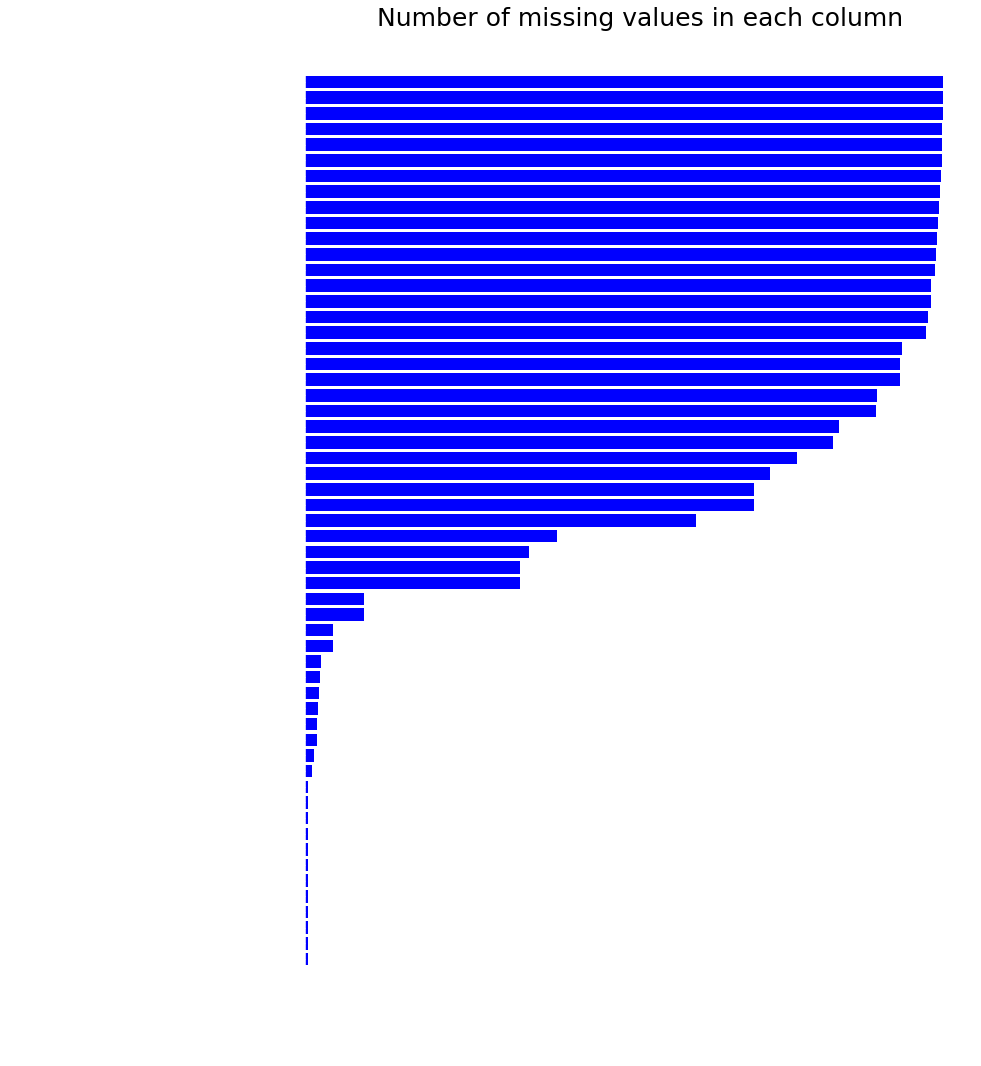

In [10]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel('Count of missing values')
ax.set_title('Number of missing values in each column')
plt.show()

이번에는 위도와 경도 변수에 대해 살펴보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

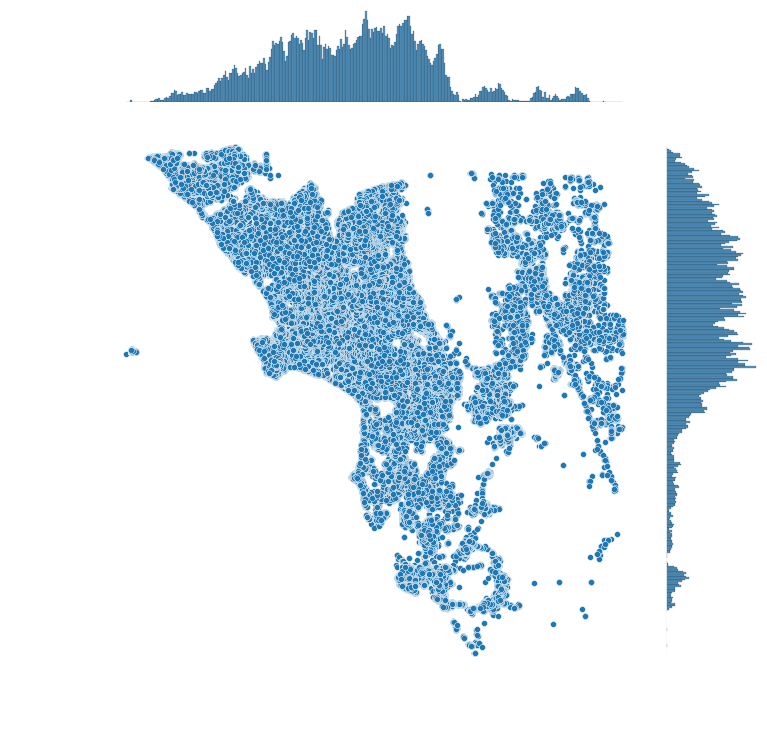

In [11]:
plt.figure(figsize=(12, 12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

데이터 설명에 따르면 세 나라(2016년도 로스엔젤레서, 오렌지, 벤튜라)에 대한 실 거주지의 정보를 제공 받았습니다.

훈련셋에는 90,811개의 행이 있지만, 속성 파일에는 2,985,217개의 행이 있습니다. 이 두 파일을 합치고 분석해야 합니다.

In [12]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


변수들의 데이터 타입에 대해 살펴보겠습니다.

In [13]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


대부분이 float 자료형이고 소수의 object형으로 이루어져 있습니다.

In [14]:
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


합쳐진 데이터에서 결측값을 확인해보겠습니다.

In [15]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


네 개의 컬럼이 99.9%이상의 결측치를 가짐을 알 수 있습니다.

### Univarite Analysis(일변량 분석)
매우 많은 변수들이 존재하기 때문에, 먼저 float 변수만 취한 다음 타겟 변수와의 상관 관계를 파악하여 변수들이 어떻게 연관되어 있는지 알아보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


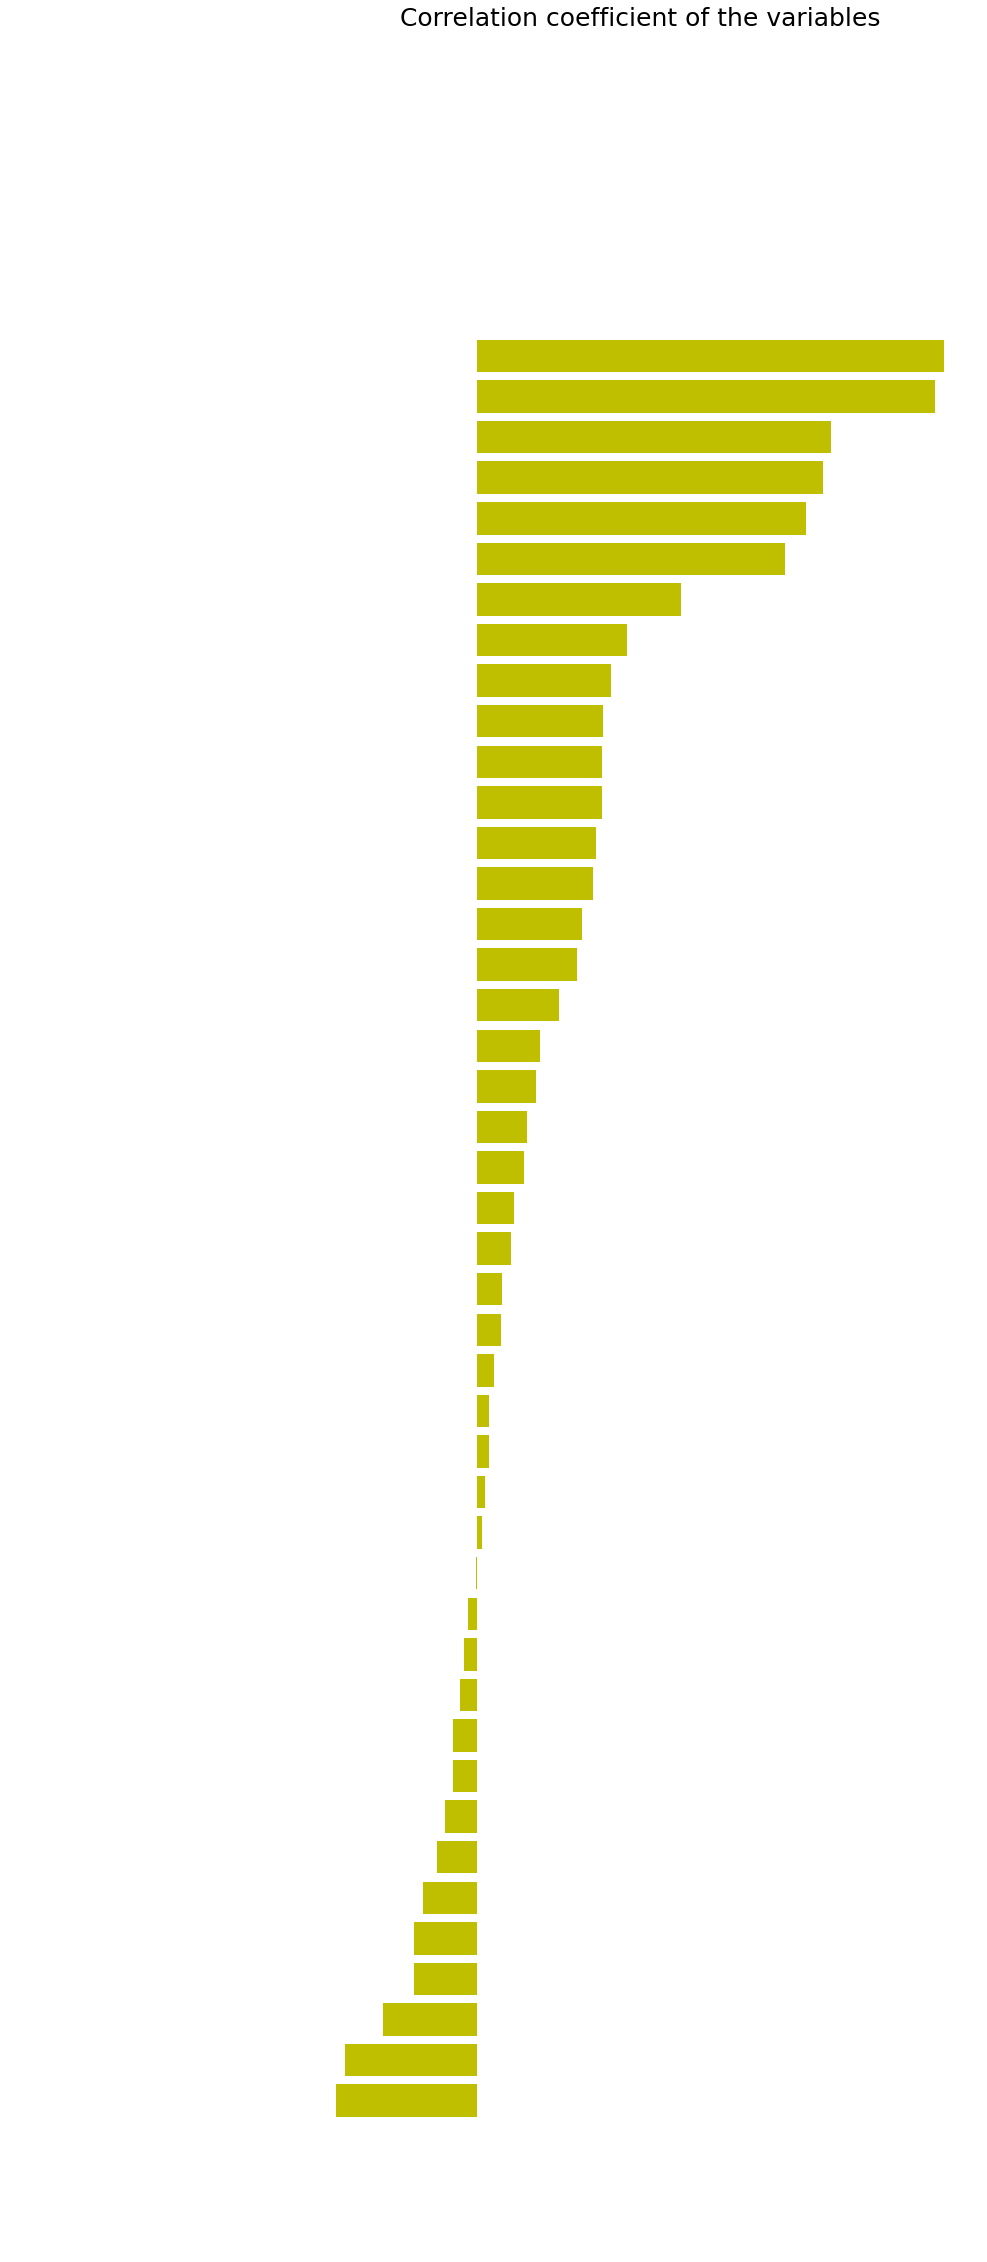

In [16]:
# 결측값을 평균값과 귀속시켜 상관 계수를 계산
mean_values = train_df.mean(axis=0)
train_df.fillna(mean_values, inplace=True)
train_df_new = train_df

# 각 변수 별로 상관 관계 계산
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')
plt.show()

대부분 타겟 변수의 상관관계는 낮습니다.

이 그래프 맨 위에 상관 값이 없는 것 처럼 나오는 변수들이 있습니다. 이들은 하나의 고유한 값만 가지고 있기 때문에 이처럼 나오는 것 같습니다. 한번 확인해보겠습니다.

In [17]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


상관 관계가 그나마 높게 나왔던 변수들에 대해 분석해보겠습니다,

In [18]:
corr_df_sel = corr_df[(corr_df['corr_values']>0.02) | (corr_df['corr_values']<-0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


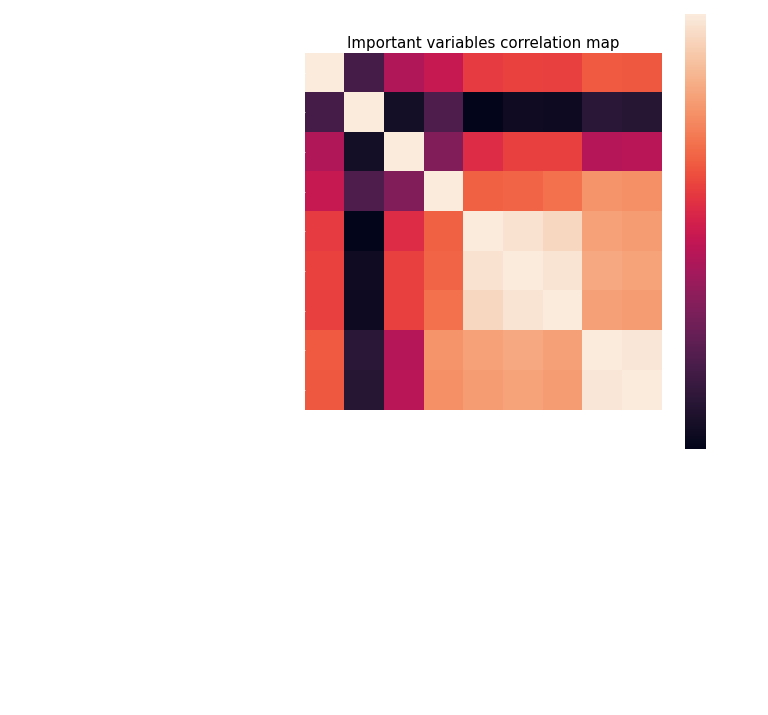

In [19]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# 히트맵
sns.heatmap(corrmat, vmax=1., square=True)
plt.title('Important variables correlation map', fontsize=15)
plt.show()

중요 변수들 자체는 매우 높은 상관관계를 가지고 있습니다. 이제 각 항목을 살펴보겠습니다.

### Finished SquareFeet 12:
finished squarefeet 12 피쳐와 logerror을 살펴보겠습니다.

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

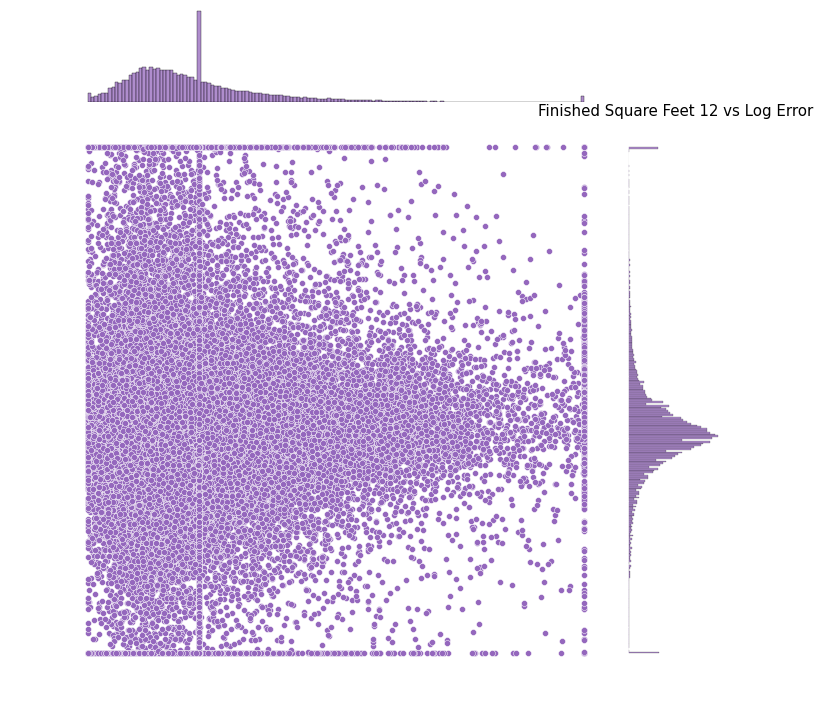

In [20]:
col = 'finishedsquarefeet12'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col][train_df[col]>ulimit] = ulimit
train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=15)
plt.title('Finished Square Feet 12 vs Log Error', fontsize=15)
plt.show()

square feet 12 변수가 증가함에 따라 logerror 범위가 좁아지는 것 같습니다. 아마 더 큰 집은 예측하기 쉬운 것을 의미하는 걸까요?

### Calculated finished square feet

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

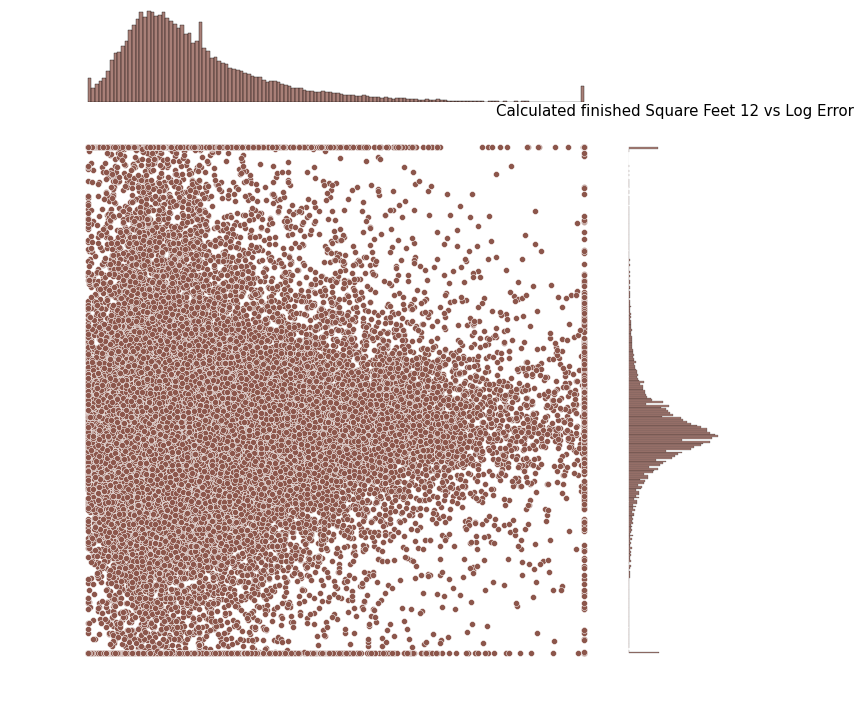

In [21]:
col = 'calculatedfinishedsquarefeet'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col][train_df[col]>ulimit] = ulimit
train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished Square Feet 12', fontsize=15)
plt.title('Calculated finished Square Feet 12 vs Log Error', fontsize=15)
plt.show()

지난 그림과 분포가 매우 유사합니다. 두 변수 사이의 상관 관계도 높은 것은 당연합니다.

### Bathroom Count

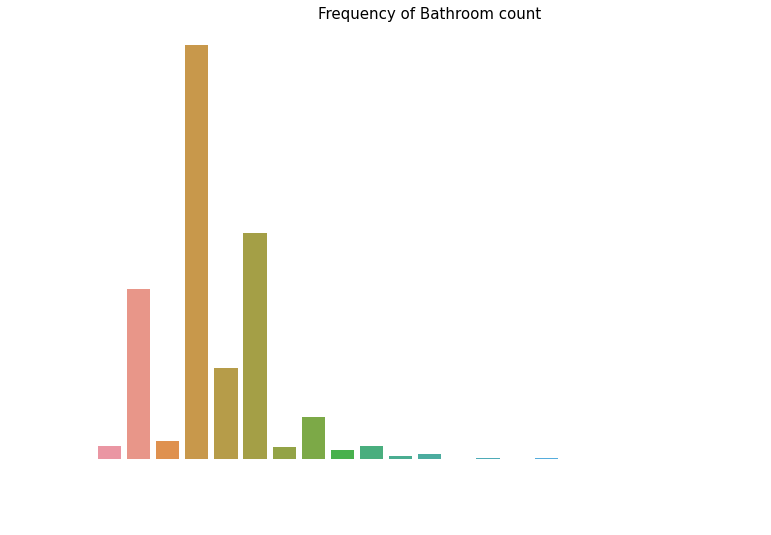

In [22]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bathroomcnt', data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Bathroom count', fontsize=15)
plt.show()

이를 기반으로 logerror가 어떻게 변경되는지 확인해 보겠습니다.

Text(0.5, 1.0, 'How log error changes with bathroom count?')

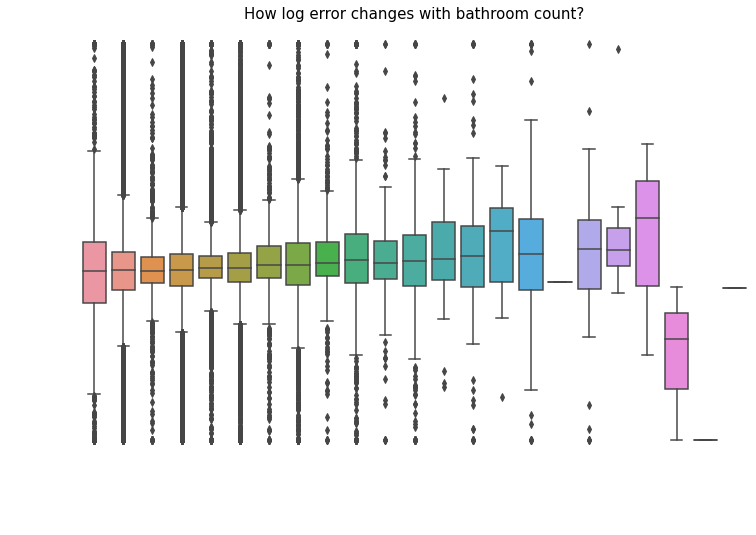

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='bathroomcnt', y='logerror', data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('How log error changes with bathroom count?', fontsize=15)

### Bedroom count

Text(0.5, 1.0, 'Frequency of Bedroom count')

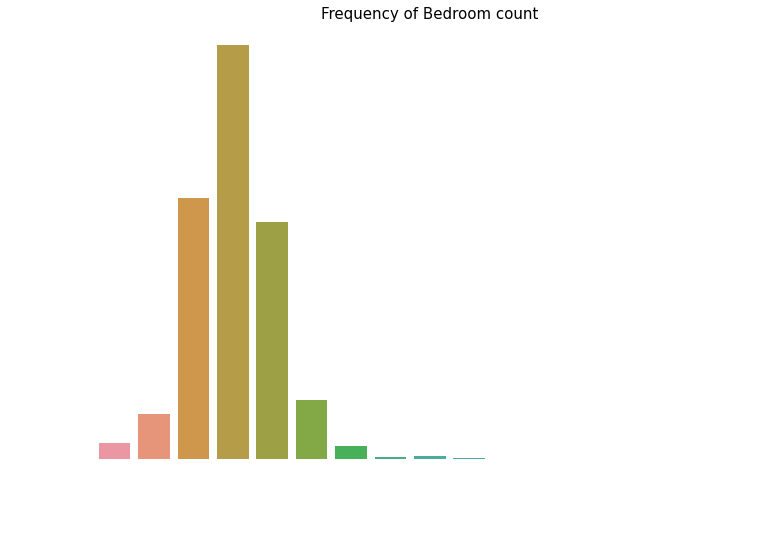

In [24]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bedroomcnt', data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Bedroom count', fontsize=15)


Text(0, 0.5, 'Log Error')

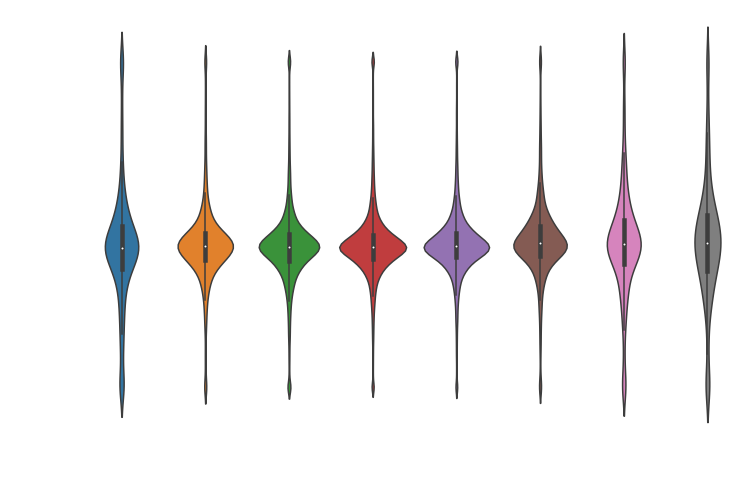

In [25]:
train_df['bedroomcnt'][train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12, 8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

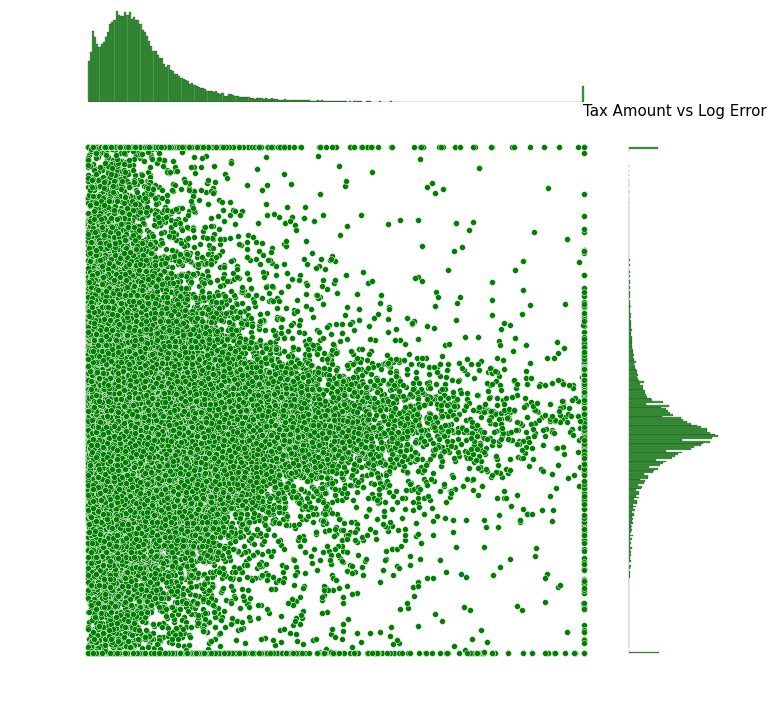

In [26]:
col = 'taxamount'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col][train_df[col]>ulimit] = ulimit
train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12, 12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=15)
plt.title('Tax Amount vs Log Error', fontsize=15)
plt.show()

### YearBuilt
해당 변수에 따라 에러 값이 어떻게 바뀌는지 살펴보겠습니다.

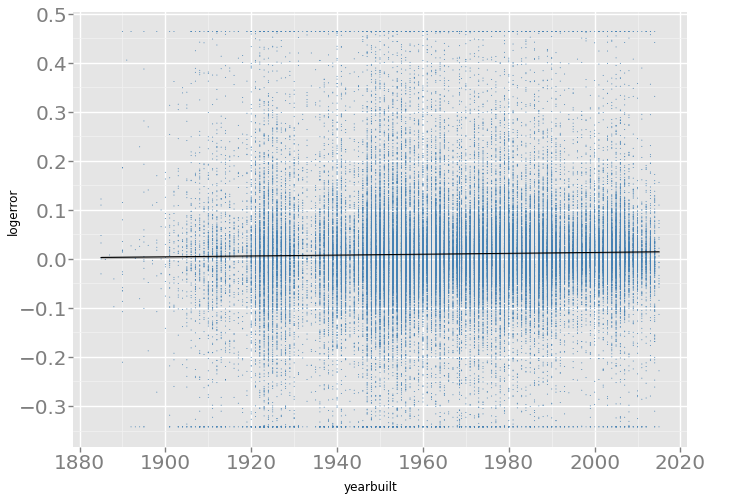

<ggplot: (-9223371930129163620)>

In [28]:
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + geom_point(color='steelblue', size=1) + stat_smooth()

건설 연도와 관련하여 소폭의 증가 추세가 나타나고 있습니다.

이제 위도 및 경도에 따라 logerror가 어떻게 변하는지 살펴보겠습니다.

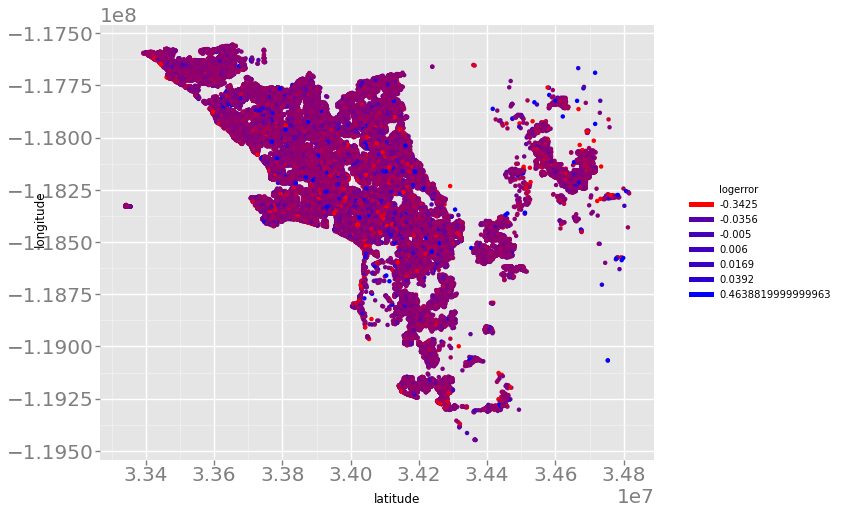

<ggplot: (-9223371929986855552)>

In [30]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + geom_point() + scale_color_gradient(low='red', high='blue')

적어도 육안으로는 위도나 경도 관련하여 보이는 특이점은 없습니다.

양의 상관관계가 가장 높고 음의 상관관계가 가장 높은 변수를 사용하여 몇 가지 가시적인 패턴을 볼 수 있는지 알아보겠습니다.

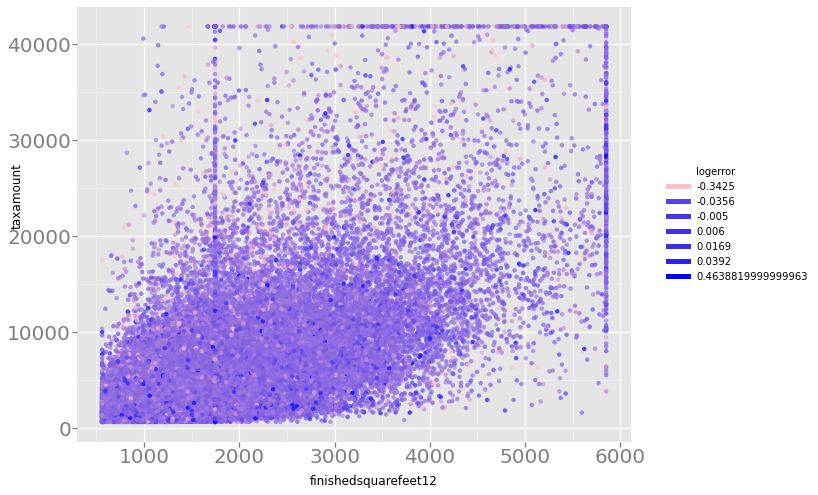

<ggplot: (-9223371929980580124)>

In [31]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + geom_point(alpha=0.7) + scale_color_gradient(low='pink', high='blue')

여기도 눈에 띄는 점은 없습니다. 그래서 이는 예측하기 힘든 경쟁이 될 것 같습니다.

재미로, 임의의 패턴을 생성해보겠습니다.

Put a bird on it!


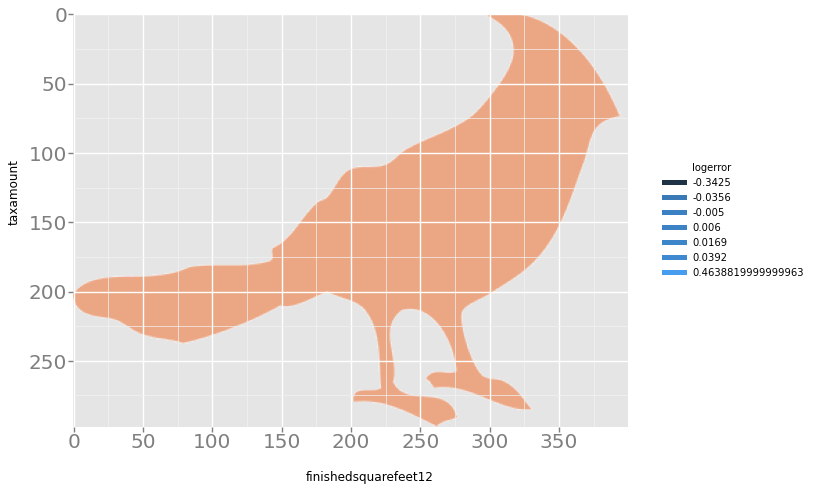

<ggplot: (-9223371929977599976)>

In [32]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + geom_now_its_art()

우리는 일변량 분석을 통해 중요한 변수를 이해했습니다. 하지만 이것은 독립적인 기준이며 또한 선형성 가정도 가지고 있습니다. 이제 추가 트리 모델을 구축하여 중요한 변수를 얻을 수 있는 비선형 모델을 구축하겠습니다.

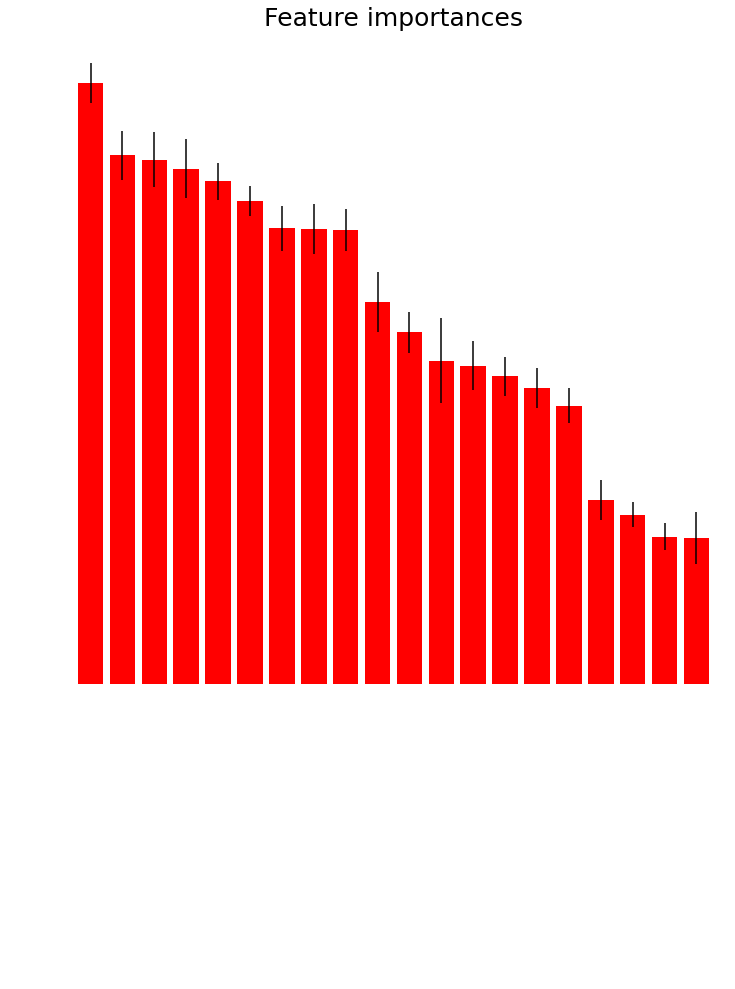

In [34]:
train_y = train_df['logerror'].values
cat_cols = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month'] + cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

# Plot Importance
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 12))
plt.title('Feature importances')
plt.bar(range(len(indices)), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

'tax amount'가 가장 중요한 변수고 그 다음이 'structure tax value dollar count' 및 'land tax value dollor count'인 것 같습니다.

[09:33:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


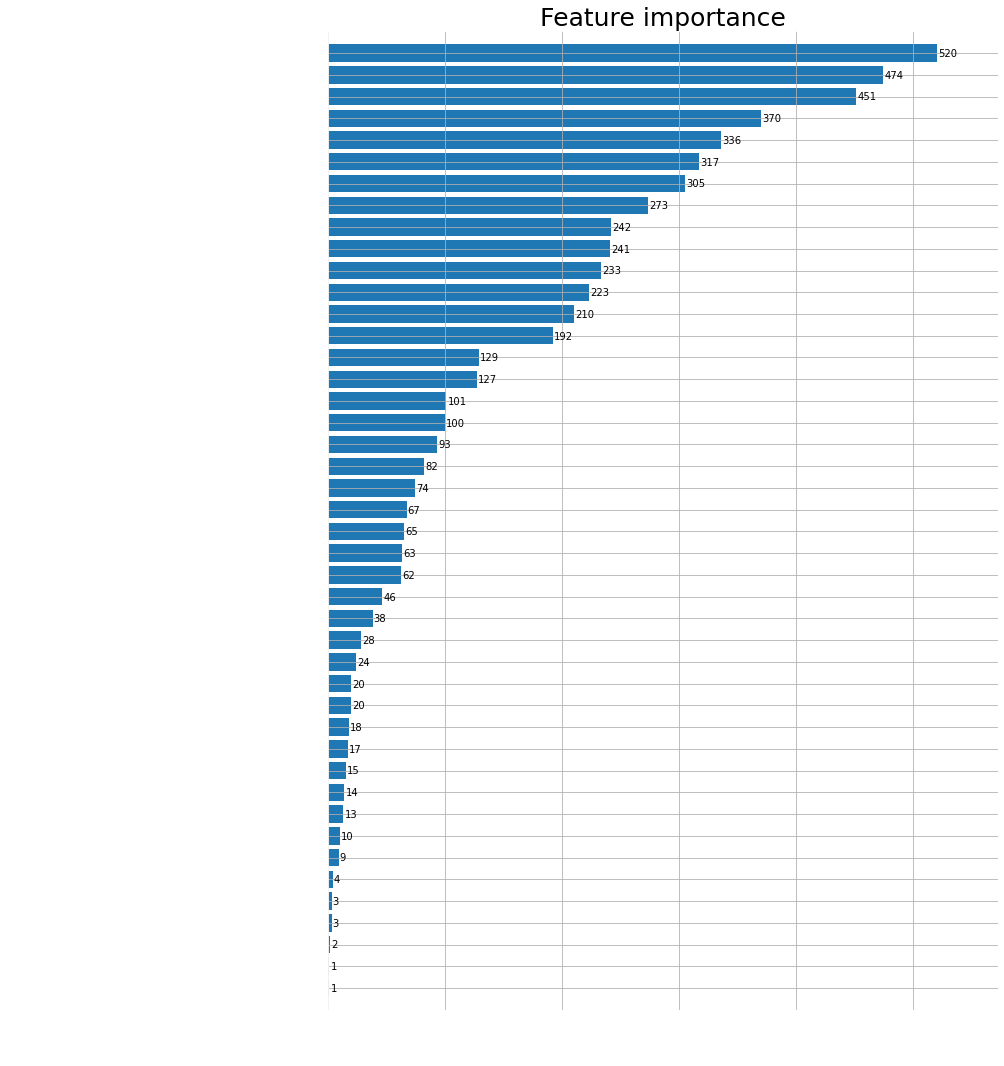

In [36]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# Plot Importance features
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

xgboost을 사용하면, 중요 변수가 'latitude', 'structured tax values dollar count' 및 'calculated finishde squarefeet'으로 나타납니다.